In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

from IPython.display import display

# Первая часть. Исследование

## Загрузка данных

In [2]:
data_train = pd.read_csv('./train.csv')
data_test = pd.read_csv('./test.csv')

### Смотрим на train

In [3]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [4]:
data_train.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [6]:
for column in data_train.select_dtypes(include=['object']):
    print(column)
    print(data_train[column].unique(), '\n')

TotalSpent
['1026.35' '1872.2' '75.9' ... '55.05' '2215.25' '1375.6'] 

Sex
['Male' 'Female'] 

HasPartner
['Yes' 'No'] 

HasChild
['Yes' 'No'] 

HasPhoneService
['Yes' 'No'] 

HasMultiplePhoneNumbers
['No' 'Yes' 'No phone service'] 

HasInternetService
['No' 'Fiber optic' 'DSL'] 

HasOnlineSecurityService
['No internet service' 'No' 'Yes'] 

HasOnlineBackup
['No internet service' 'No' 'Yes'] 

HasDeviceProtection
['No internet service' 'No' 'Yes'] 

HasTechSupportAccess
['No internet service' 'Yes' 'No'] 

HasOnlineTV
['No internet service' 'No' 'Yes'] 

HasMovieSubscription
['No internet service' 'No' 'Yes'] 

HasContractPhone
['One year' 'Two year' 'Month-to-month'] 

IsBillingPaperless
['No' 'Yes'] 

PaymentMethod
['Mailed check' 'Credit card (automatic)' 'Electronic check'
 'Bank transfer (automatic)'] 



In [7]:
print(f"Number of dublicates is : {data_train.duplicated().sum()}")

Number of dublicates is : 14


In [8]:
print(f"Total number of NaN is : {data_train.isna().sum().sum()}")

Total number of NaN is : 0


In [9]:
print(f"Number of NaN by column  : \n {data_train.isna().sum()}")

Number of NaN by column  : 
 ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64


### Смотрим на test

In [10]:
data_test.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.4,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.6,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)


In [11]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

In [12]:
print(f"Number of dublicates is : {data_test.duplicated().sum()}")

Number of dublicates is : 3


In [13]:
print(f"Total number of NaN is : {data_test.isna().sum().sum()}")

Total number of NaN is : 0


In [14]:
print(f"Number of NaN by column  : \n {data_test.isna().sum()}")

Number of NaN by column  : 
 ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
dtype: int64


### Mini cleaning

In [15]:
print(data_test.duplicated().sum() / data_test.shape[0])
print(data_train.duplicated().sum() / data_train.shape[0])

0.0017035775127768314
0.0026505111700113595


In [16]:
# Обнаружилось, что есть несколько людей с пустым TotalSpent, дадим им 0
data_train[data_train["TotalSpent"] == " "]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [17]:
data_train["TotalSpent"] = data_train["TotalSpent"].apply(lambda x: float(x) if x!=" " else 0)
data_test["TotalSpent"] = data_test["TotalSpent"].apply(lambda x: float(x) if x!=" " else 0)

In [18]:
data_train.dtypes

ClientPeriod                  int64
MonthlySpending             float64
TotalSpent                  float64
Sex                          object
IsSeniorCitizen               int64
HasPartner                   object
HasChild                     object
HasPhoneService              object
HasMultiplePhoneNumbers      object
HasInternetService           object
HasOnlineSecurityService     object
HasOnlineBackup              object
HasDeviceProtection          object
HasTechSupportAccess         object
HasOnlineTV                  object
HasMovieSubscription         object
HasContractPhone             object
IsBillingPaperless           object
PaymentMethod                object
Churn                         int64
dtype: object

# Анализ данных

In [19]:
def count_outliers(df, feature_name):
    Q1 = df[feature_name].quantile(0.25)
    Q3 = df[feature_name].quantile(0.75)
    IQR = Q3 - Q1
    
    return df[feature_name][(df[feature_name] > Q3 + 1.5*IQR) | (df[feature_name] < Q1 - 1.5*IQR)].count()

def plot_cat_feature_bar(df, feature_name, ax):
    return sns.barplot(
        x=df[feature_name].value_counts().index,
        y=df[feature_name].value_counts(),
        ax=ax
    )

## Смотрим на целевую переменную

In [20]:
data_train

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,3,30.40,82.15,Male,0,No,No,No,No phone service,DSL,No,No,No,Yes,No,No,Month-to-month,No,Electronic check,0
5278,50,44.45,2188.45,Male,0,Yes,No,No,No phone service,DSL,Yes,No,No,Yes,Yes,No,One year,Yes,Bank transfer (automatic),0
5279,1,55.05,55.05,Male,0,No,No,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Mailed check,0
5280,29,76.00,2215.25,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),0


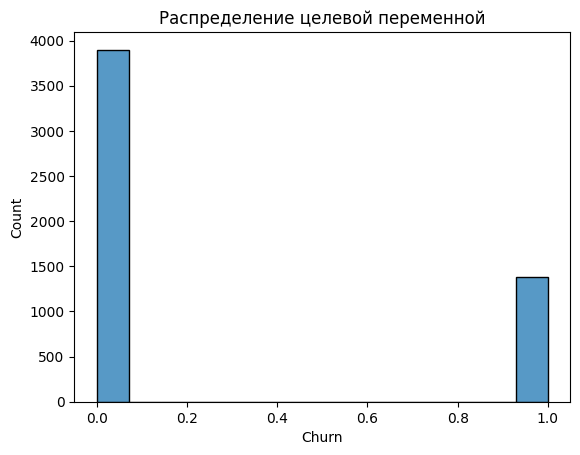

In [21]:
ax = sns.histplot(data=data_train, x="Churn")
ax.set_title("Распределение целевой переменной")
None

In [22]:
print(f"Класс 0 встречается чаще 1 в {data_train.Churn.value_counts()[0] / data_train.Churn.value_counts()[1]} раз")

Класс 0 встречается чаще 1 в 2.816473988439306 раз


* Классы несбалансированны, но не сильно.

### Посмотрим на категориальные признаки

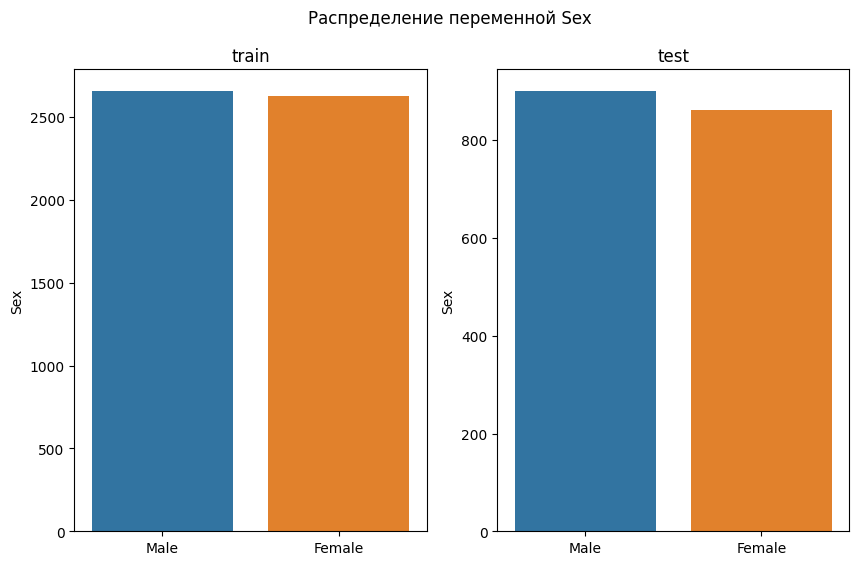

Распределение целевой пременной в зависимости от Sex


Sex     Churn
Female  0        1929
        1         698
Male    0        1969
        1         686
Name: Churn, dtype: int64

Распределение целевой пременной в зависимости от Sex в процентах


Sex     Churn
Female  0        0.734298
        1        0.265702
Male    0        0.741620
        1        0.258380
Name: Churn, dtype: float64

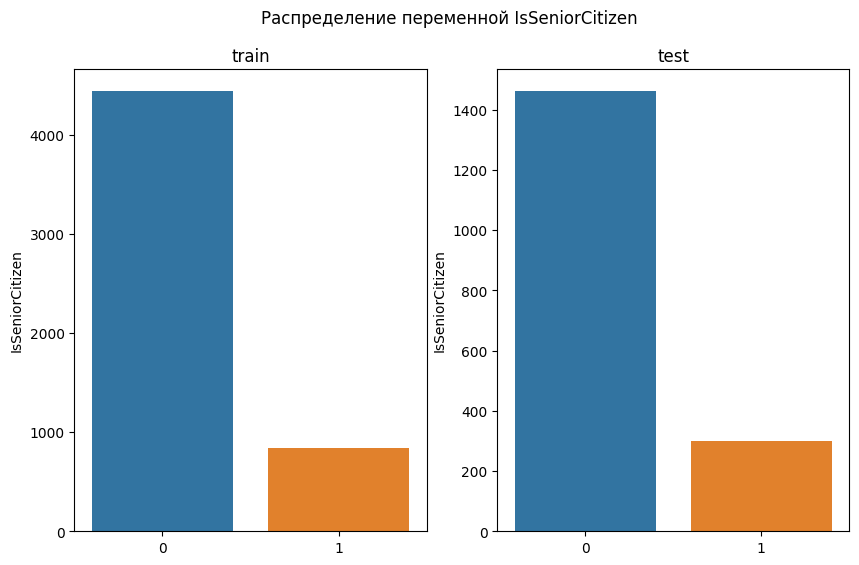

Распределение целевой пременной в зависимости от IsSeniorCitizen


IsSeniorCitizen  Churn
0                0        3410
                 1        1030
1                0         488
                 1         354
Name: Churn, dtype: int64

Распределение целевой пременной в зависимости от IsSeniorCitizen в процентах


IsSeniorCitizen  Churn
0                0        0.768018
                 1        0.231982
1                0        0.579572
                 1        0.420428
Name: Churn, dtype: float64

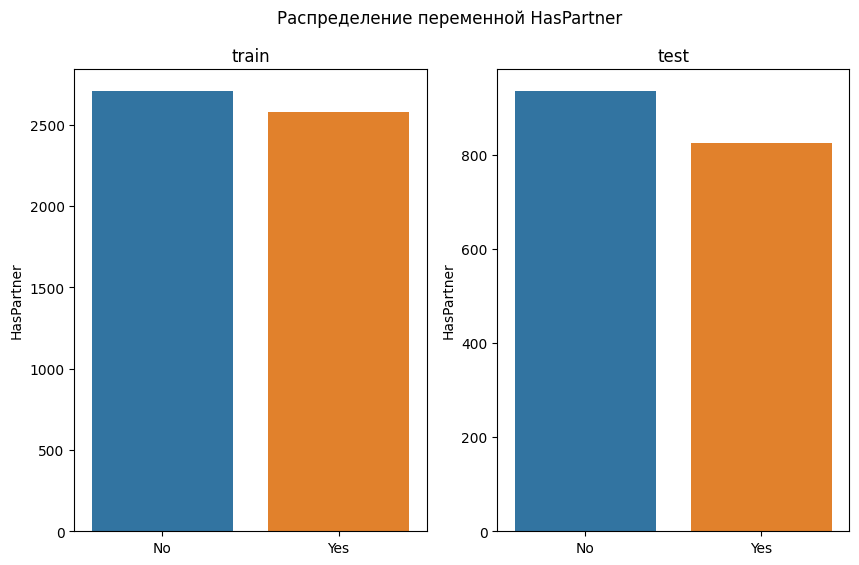

Распределение целевой пременной в зависимости от HasPartner


HasPartner  Churn
No          0        1824
            1         881
Yes         0        2074
            1         503
Name: Churn, dtype: int64

Распределение целевой пременной в зависимости от HasPartner в процентах


HasPartner  Churn
No          0        0.674307
            1        0.325693
Yes         0        0.804812
            1        0.195188
Name: Churn, dtype: float64

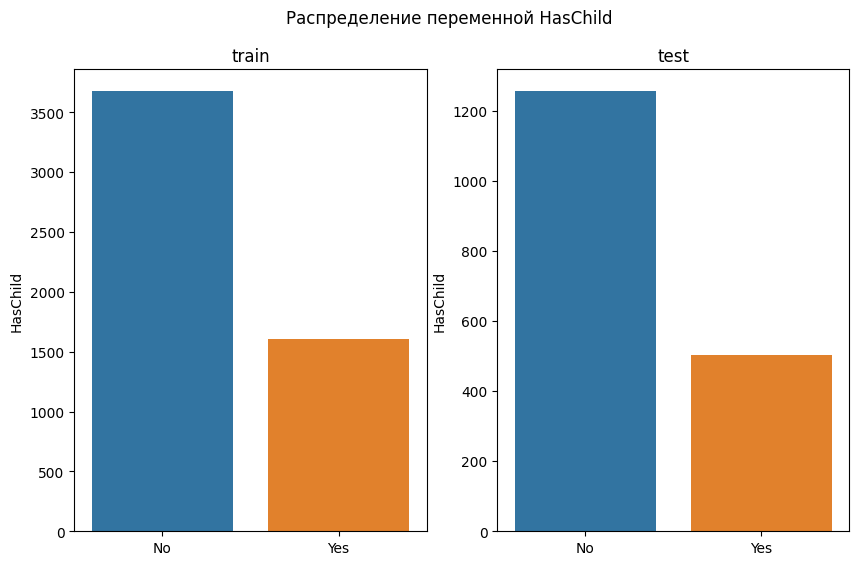

Распределение целевой пременной в зависимости от HasChild


HasChild  Churn
No        0        2538
          1        1138
Yes       0        1360
          1         246
Name: Churn, dtype: int64

Распределение целевой пременной в зависимости от HasChild в процентах


HasChild  Churn
No        0        0.690424
          1        0.309576
Yes       0        0.846824
          1        0.153176
Name: Churn, dtype: float64

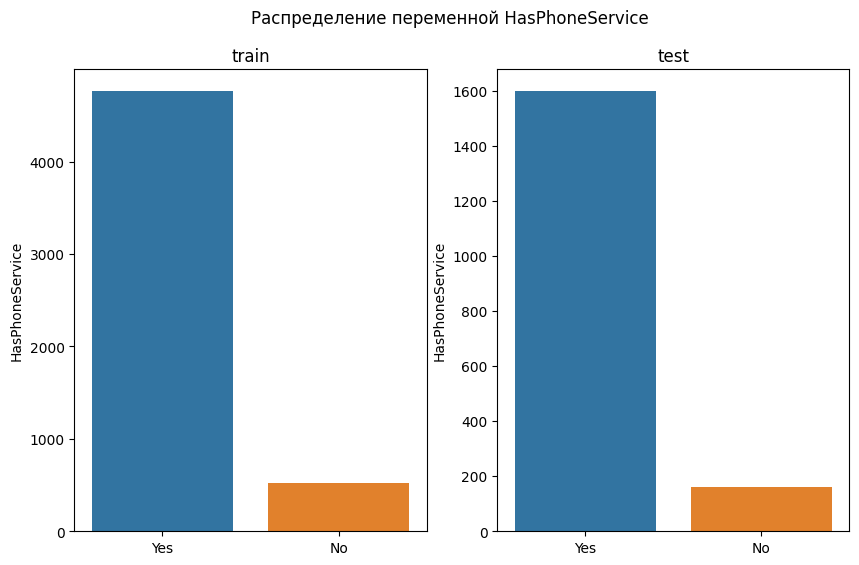

Распределение целевой пременной в зависимости от HasPhoneService


HasPhoneService  Churn
No               0         392
                 1         129
Yes              0        3506
                 1        1255
Name: Churn, dtype: int64

Распределение целевой пременной в зависимости от HasPhoneService в процентах


HasPhoneService  Churn
No               0        0.752399
                 1        0.247601
Yes              0        0.736400
                 1        0.263600
Name: Churn, dtype: float64

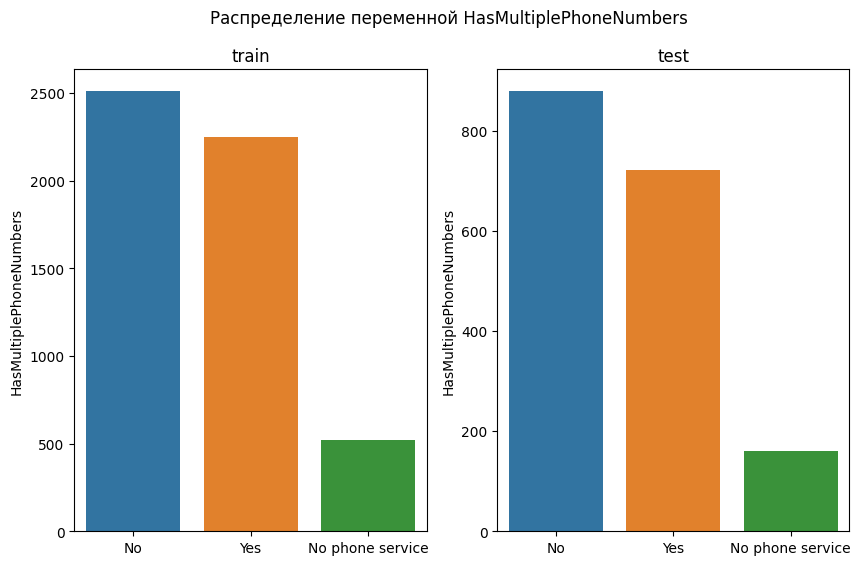

Распределение целевой пременной в зависимости от HasMultiplePhoneNumbers


HasMultiplePhoneNumbers  Churn
No                       0        1891
                         1         620
No phone service         0         392
                         1         129
Yes                      0        1615
                         1         635
Name: Churn, dtype: int64

Распределение целевой пременной в зависимости от HasMultiplePhoneNumbers в процентах


HasMultiplePhoneNumbers  Churn
No                       0        0.753086
                         1        0.246914
No phone service         0        0.752399
                         1        0.247601
Yes                      0        0.717778
                         1        0.282222
Name: Churn, dtype: float64

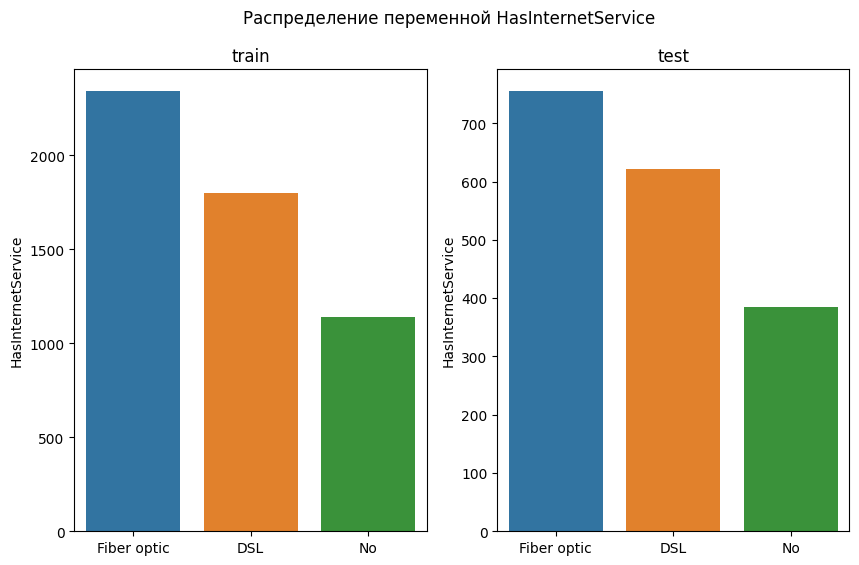

Распределение целевой пременной в зависимости от HasInternetService


HasInternetService  Churn
DSL                 0        1458
                    1         342
Fiber optic         0        1381
                    1         960
No                  0        1059
                    1          82
Name: Churn, dtype: int64

Распределение целевой пременной в зависимости от HasInternetService в процентах


HasInternetService  Churn
DSL                 0        0.810000
                    1        0.190000
Fiber optic         0        0.589919
                    1        0.410081
No                  0        0.928133
                    1        0.071867
Name: Churn, dtype: float64

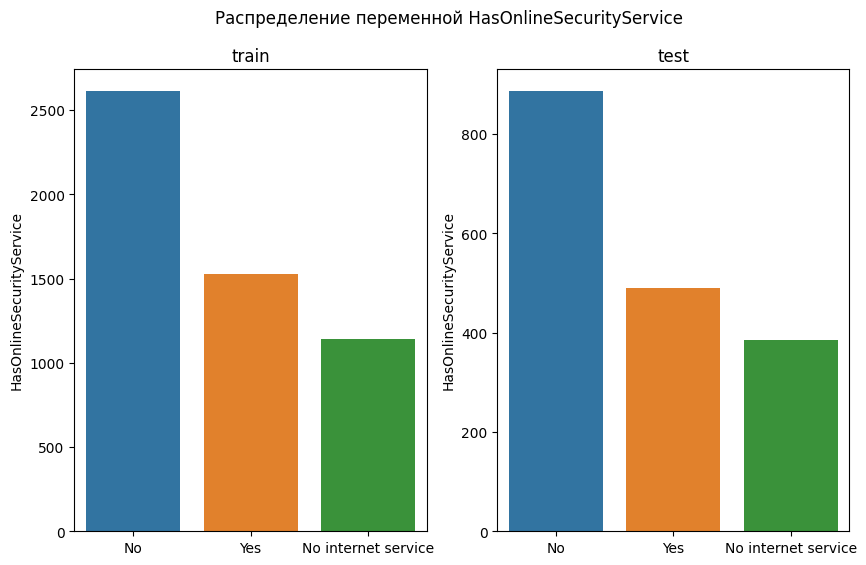

Распределение целевой пременной в зависимости от HasOnlineSecurityService


HasOnlineSecurityService  Churn
No                        0        1518
                          1        1094
No internet service       0        1059
                          1          82
Yes                       0        1321
                          1         208
Name: Churn, dtype: int64

Распределение целевой пременной в зависимости от HasOnlineSecurityService в процентах


HasOnlineSecurityService  Churn
No                        0        0.581164
                          1        0.418836
No internet service       0        0.928133
                          1        0.071867
Yes                       0        0.863963
                          1        0.136037
Name: Churn, dtype: float64

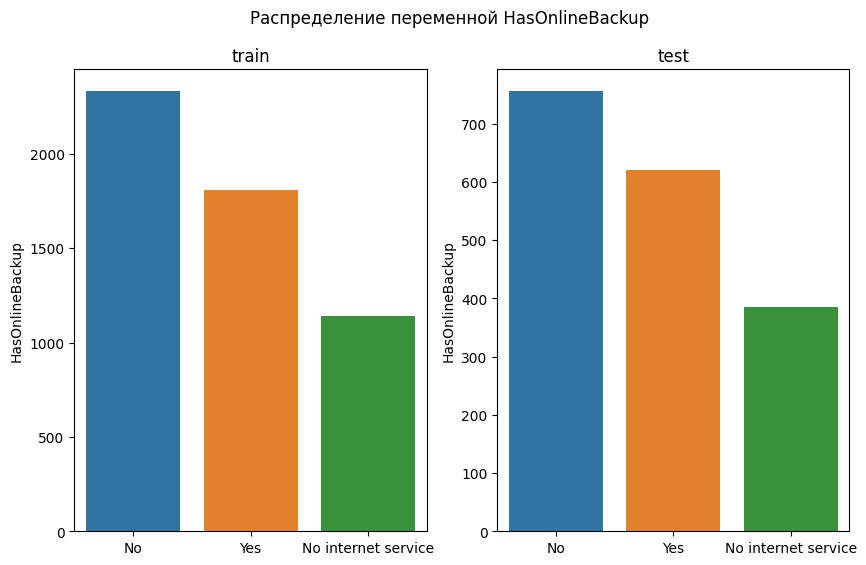

Распределение целевой пременной в зависимости от HasOnlineBackup


HasOnlineBackup      Churn
No                   0        1407
                     1         925
No internet service  0        1059
                     1          82
Yes                  0        1432
                     1         377
Name: Churn, dtype: int64

Распределение целевой пременной в зависимости от HasOnlineBackup в процентах


HasOnlineBackup      Churn
No                   0        0.603345
                     1        0.396655
No internet service  0        0.928133
                     1        0.071867
Yes                  0        0.791598
                     1        0.208402
Name: Churn, dtype: float64

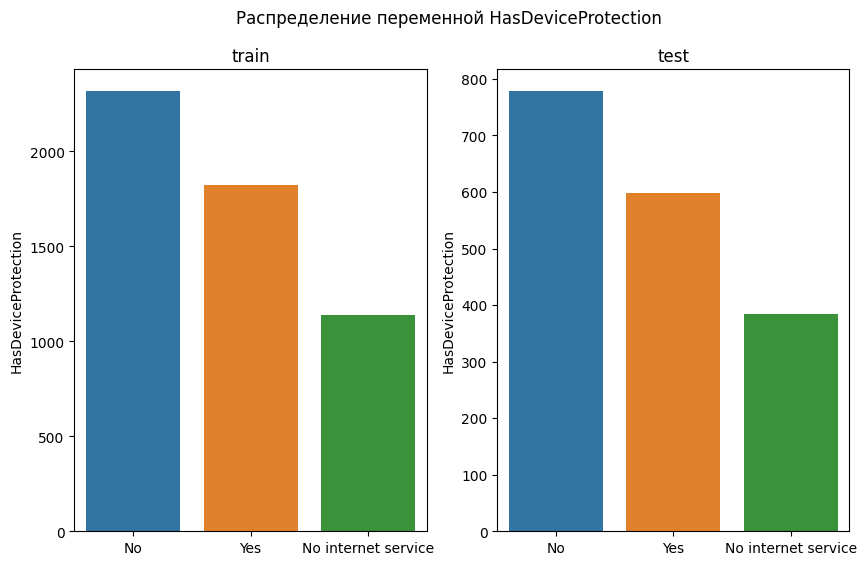

Распределение целевой пременной в зависимости от HasDeviceProtection


HasDeviceProtection  Churn
No                   0        1417
                     1         900
No internet service  0        1059
                     1          82
Yes                  0        1422
                     1         402
Name: Churn, dtype: int64

Распределение целевой пременной в зависимости от HasDeviceProtection в процентах


HasDeviceProtection  Churn
No                   0        0.611567
                     1        0.388433
No internet service  0        0.928133
                     1        0.071867
Yes                  0        0.779605
                     1        0.220395
Name: Churn, dtype: float64

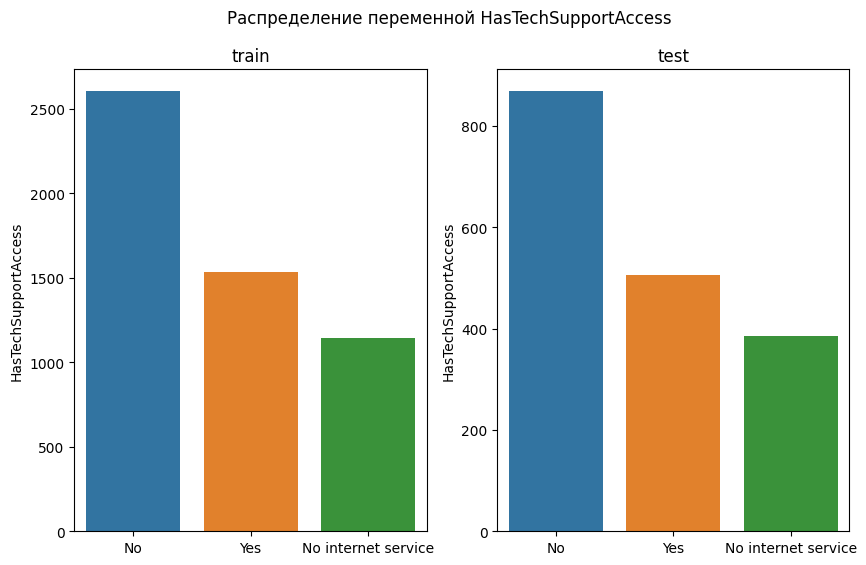

Распределение целевой пременной в зависимости от HasTechSupportAccess


HasTechSupportAccess  Churn
No                    0        1530
                      1        1074
No internet service   0        1059
                      1          82
Yes                   0        1309
                      1         228
Name: Churn, dtype: int64

Распределение целевой пременной в зависимости от HasTechSupportAccess в процентах


HasTechSupportAccess  Churn
No                    0        0.587558
                      1        0.412442
No internet service   0        0.928133
                      1        0.071867
Yes                   0        0.851659
                      1        0.148341
Name: Churn, dtype: float64

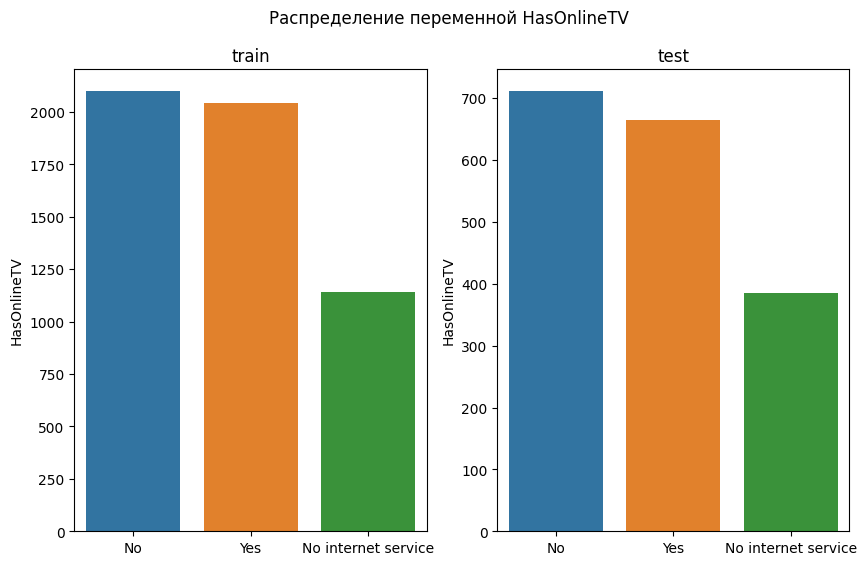

Распределение целевой пременной в зависимости от HasOnlineTV


HasOnlineTV          Churn
No                   0        1399
                     1         700
No internet service  0        1059
                     1          82
Yes                  0        1440
                     1         602
Name: Churn, dtype: int64

Распределение целевой пременной в зависимости от HasOnlineTV в процентах


HasOnlineTV          Churn
No                   0        0.666508
                     1        0.333492
No internet service  0        0.928133
                     1        0.071867
Yes                  0        0.705191
                     1        0.294809
Name: Churn, dtype: float64

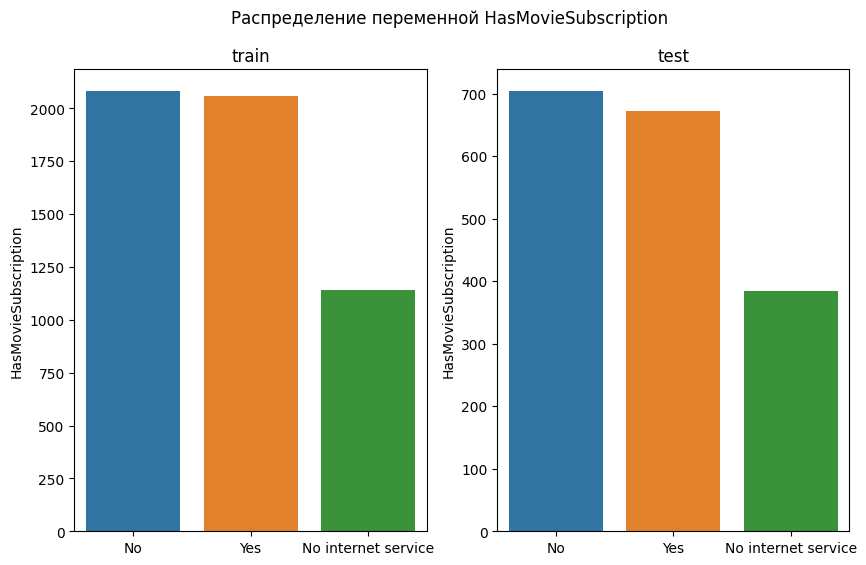

Распределение целевой пременной в зависимости от HasMovieSubscription


HasMovieSubscription  Churn
No                    0        1376
                      1         705
No internet service   0        1059
                      1          82
Yes                   0        1463
                      1         597
Name: Churn, dtype: int64

Распределение целевой пременной в зависимости от HasMovieSubscription в процентах


HasMovieSubscription  Churn
No                    0        0.661221
                      1        0.338779
No internet service   0        0.928133
                      1        0.071867
Yes                   0        0.710194
                      1        0.289806
Name: Churn, dtype: float64

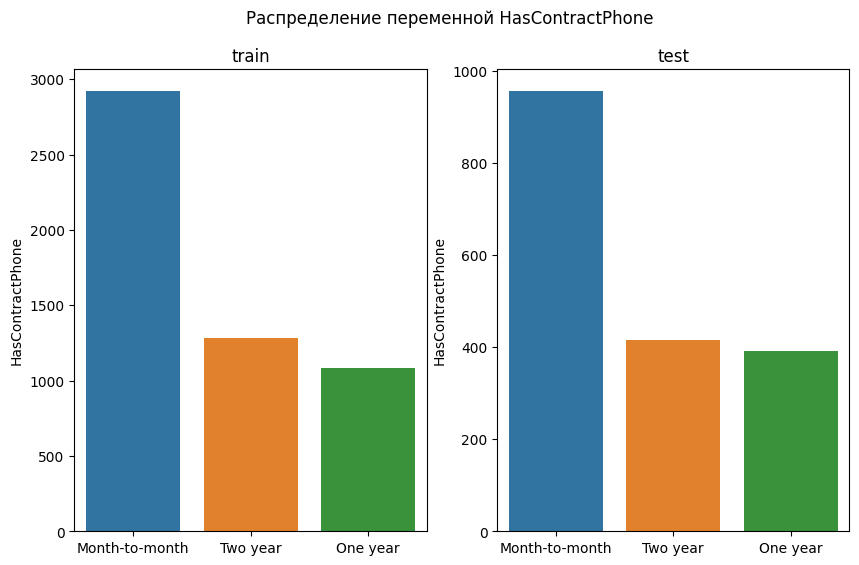

Распределение целевой пременной в зависимости от HasContractPhone


HasContractPhone  Churn
Month-to-month    0        1689
                  1        1231
One year          0         962
                  1         120
Two year          0        1247
                  1          33
Name: Churn, dtype: int64

Распределение целевой пременной в зависимости от HasContractPhone в процентах


HasContractPhone  Churn
Month-to-month    0        0.578425
                  1        0.421575
One year          0        0.889094
                  1        0.110906
Two year          0        0.974219
                  1        0.025781
Name: Churn, dtype: float64

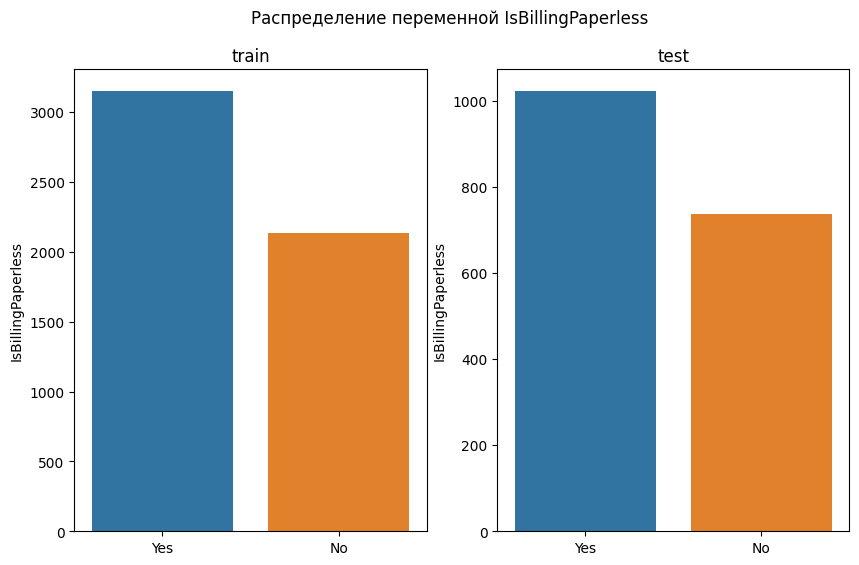

Распределение целевой пременной в зависимости от IsBillingPaperless


IsBillingPaperless  Churn
No                  0        1796
                    1         338
Yes                 0        2102
                    1        1046
Name: Churn, dtype: int64

Распределение целевой пременной в зависимости от IsBillingPaperless в процентах


IsBillingPaperless  Churn
No                  0        0.841612
                    1        0.158388
Yes                 0        0.667726
                    1        0.332274
Name: Churn, dtype: float64

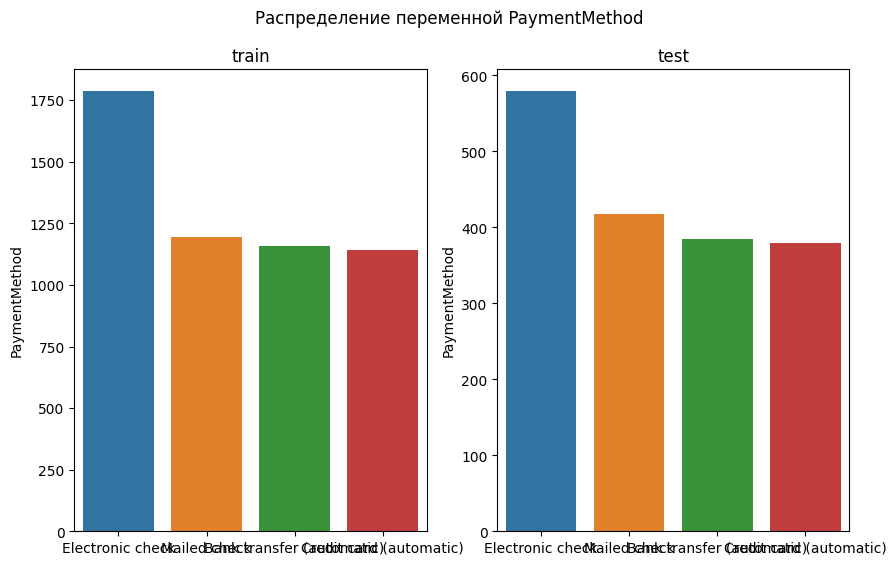

Распределение целевой пременной в зависимости от PaymentMethod


PaymentMethod              Churn
Bank transfer (automatic)  0        964
                           1        195
Credit card (automatic)    0        978
                           1        165
Electronic check           0        992
                           1        794
Mailed check               0        964
                           1        230
Name: Churn, dtype: int64

Распределение целевой пременной в зависимости от PaymentMethod в процентах


PaymentMethod              Churn
Bank transfer (automatic)  0        0.831752
                           1        0.168248
Credit card (automatic)    0        0.855643
                           1        0.144357
Electronic check           0        0.555431
                           1        0.444569
Mailed check               0        0.807370
                           1        0.192630
Name: Churn, dtype: float64

In [23]:
for i in range(len(cat_cols)):
    fig, ax = plt.subplots(1, 2, figsize=(10,6))
    ax_train = plot_cat_feature_bar(data_train, cat_cols[i], ax=ax[0])
    ax_test = plot_cat_feature_bar(data_test, cat_cols[i], ax=ax[1])
    
    ax_train.set_title("train")
    ax_test.set_title("test")
    fig.suptitle(f"Распределение переменной {cat_cols[i]}")
    plt.show()
    
    print(f"Распределение целевой пременной в зависимости от {cat_cols[i]}")
    display(
        data_train.groupby(cat_cols[i])['Churn'].value_counts()
    )
    print(f"Распределение целевой пременной в зависимости от {cat_cols[i]} в процентах")
    display(
        data_train.groupby(cat_cols[i])['Churn'].value_counts() / data_train.groupby(cat_cols[i])['Churn'].count()
    )
    print()

* Сильной разницы между train и test нет

### Посмотрим на числовые признаки

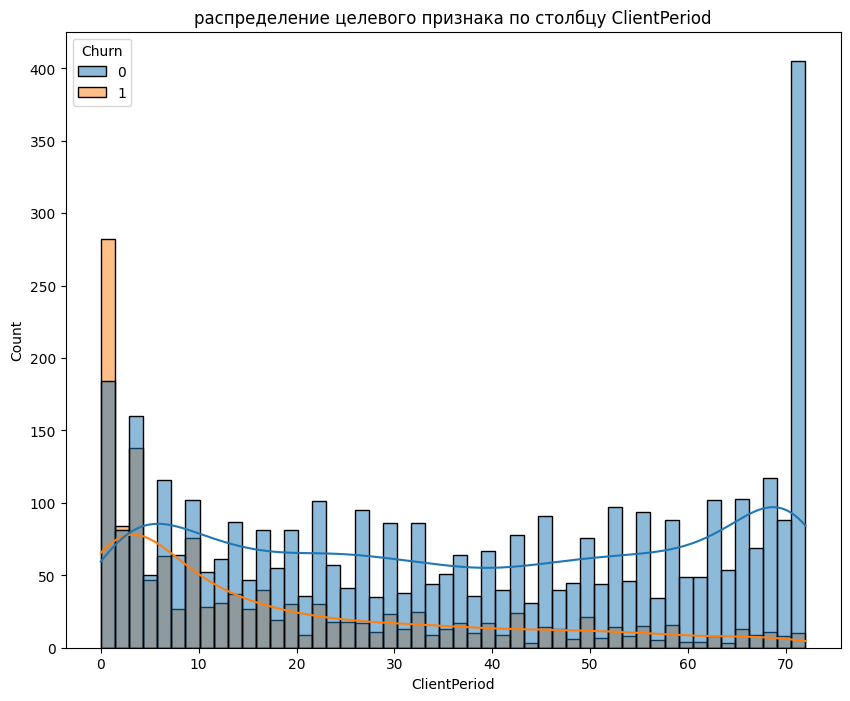

Описательные статистики по столбцу ClientPeriod в зависимости от статуса


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,3898.0,37.525911,24.123750,0.0,15.0,37.0,61.0,72.0
1,1384.0,17.951590,19.460135,1.0,2.0,10.0,29.0,72.0


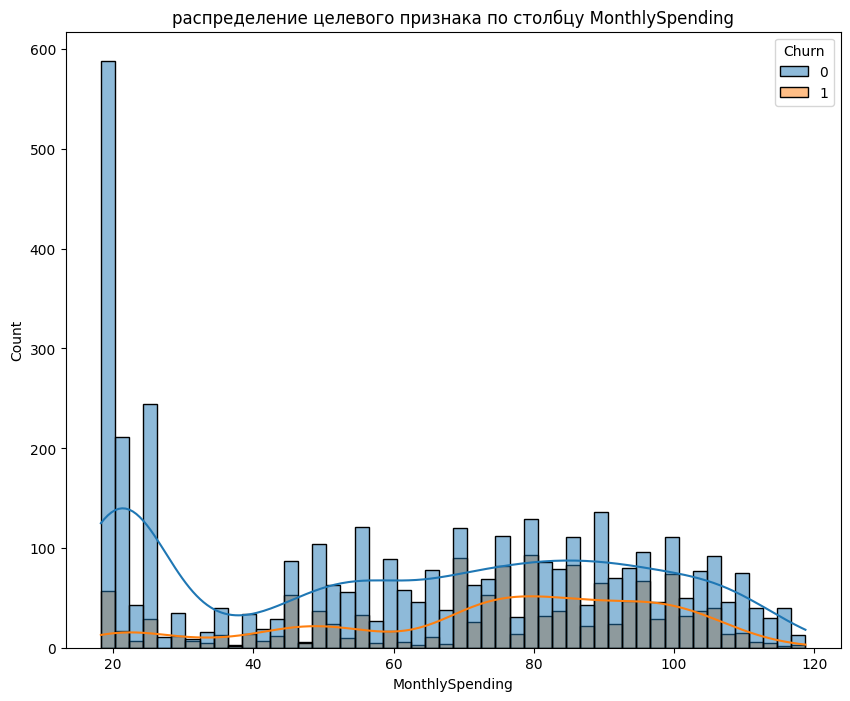

Описательные статистики по столбцу MonthlySpending в зависимости от статуса


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,3898.0,61.602719,31.272608,18.25,25.1000,64.775,89.1,118.75
1,1384.0,74.281178,24.551353,18.95,56.4375,79.500,94.2,118.35


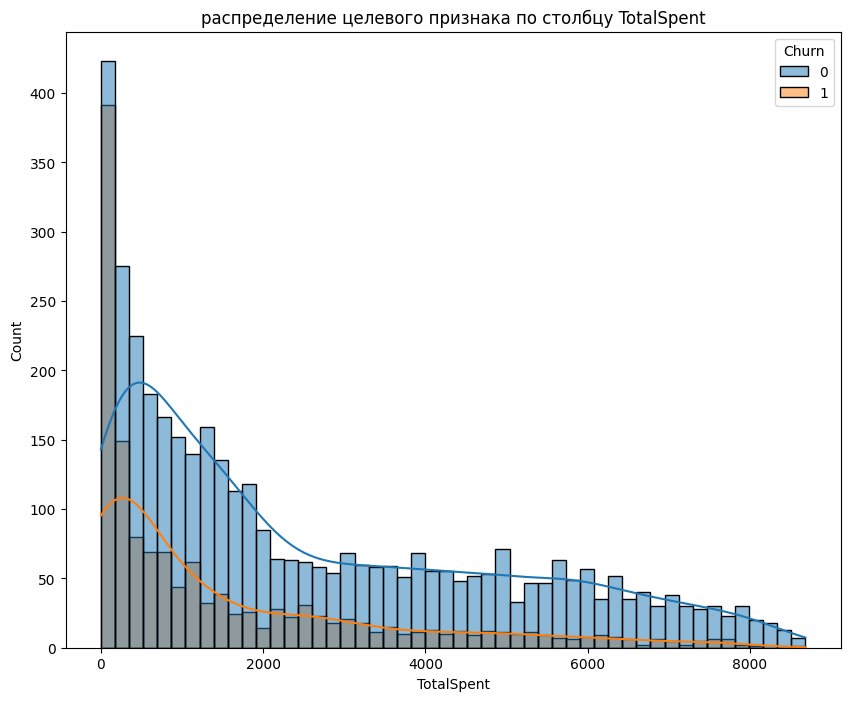

Описательные статистики по столбцу TotalSpent в зависимости от статуса


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,3898.0,2557.914469,2332.736235,0.0,564.4625,1709.125,4273.60,8672.45
1,1384.0,1525.831864,1881.443058,19.1,134.6500,706.725,2352.55,8684.80


In [24]:
for i, feature in enumerate(num_cols):
    fig, ax = plt.subplots(1, 1, figsize=(10,8))
    sns.histplot(
        data=data_train, 
        x=feature, 
        ax=ax, 
        hue='Churn',
        kde=True,
        bins=50
    )
    ax.set_title(f"распределение целевого признака по столбцу {feature}")
    plt.show()
    print(f"Описательные статистики по столбцу {feature} в зависимости от статуса")
    display(
        data_train.groupby('Churn')[feature].describe()
    )

### Немного преобразуем признаки

In [25]:
train_preprocessed = data_train.copy()
test_preprocessed = data_test.copy()

In [26]:
for column in ['HasPartner','HasChild','HasPhoneService','IsBillingPaperless']:
    train_preprocessed[column] = train_preprocessed[column].apply({'Yes': 1, 'No': 0}.get)
    
train_preprocessed['Sex'] = train_preprocessed['Sex'].apply({'Male': 1, 'Female': 0}.get)

In [90]:
for column in ['HasPartner','HasChild','HasPhoneService','IsBillingPaperless']:
    test_preprocessed[column] = test_preprocessed[column].apply({'Yes': 1, 'No': 0}.get)
    
test_preprocessed['Sex'] = test_preprocessed['Sex'].apply({'Male': 1, 'Female': 0}.get)

## Посмотрим на корреляции

In [27]:
train_preprocessed.corr()

C:\Users\Windows\AppData\Local\Temp\ipykernel_3216\582108734.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_preprocessed.corr()


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,IsBillingPaperless,Churn
ClientPeriod,1.000000,0.249414,0.826658,0.006370,0.011561,0.370314,0.146120,0.013291,0.008711,-0.350640
MonthlySpending,0.249414,1.000000,0.652014,-0.011778,0.215456,0.087652,-0.125682,0.251283,0.344868,0.184769
TotalSpent,0.826658,0.652014,1.000000,0.006341,0.094640,0.308733,0.047241,0.116437,0.157007,-0.200033
Sex,0.006370,-0.011778,0.006341,1.000000,0.013207,0.002780,0.014605,-0.007771,-0.015698,-0.008325
IsSeniorCitizen,0.011561,0.215456,0.094640,0.013207,1.000000,0.016764,-0.217007,0.008763,0.151964,0.156872
HasPartner,0.370314,0.087652,0.308733,0.002780,0.016764,1.000000,0.442530,0.001508,-0.005293,-0.148347
HasChild,0.146120,-0.125682,0.047241,0.014605,-0.217007,0.442530,1.000000,-0.010475,-0.100777,-0.163609
HasPhoneService,0.013291,0.251283,0.116437,-0.007771,0.008763,0.001508,-0.010475,1.000000,0.021362,0.010849
IsBillingPaperless,0.008711,0.344868,0.157007,-0.015698,0.151964,-0.005293,-0.100777,0.021362,1.000000,0.194040
Churn,-0.350640,0.184769,-0.200033,-0.008325,0.156872,-0.148347,-0.163609,0.010849,0.194040,1.000000


In [28]:
train_preprocessed.corr()['Churn'].abs().sort_values(ascending=False)

C:\Users\Windows\AppData\Local\Temp\ipykernel_3216\2688592893.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_preprocessed.corr()['Churn'].abs().sort_values(ascending=False)


Churn                 1.000000
ClientPeriod          0.350640
TotalSpent            0.200033
IsBillingPaperless    0.194040
MonthlySpending       0.184769
HasChild              0.163609
IsSeniorCitizen       0.156872
HasPartner            0.148347
HasPhoneService       0.010849
Sex                   0.008325
Name: Churn, dtype: float64

C:\Users\Windows\AppData\Local\Temp\ipykernel_3216\4104672295.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(train_preprocessed.corr(), annot=True, fmt='.2g')


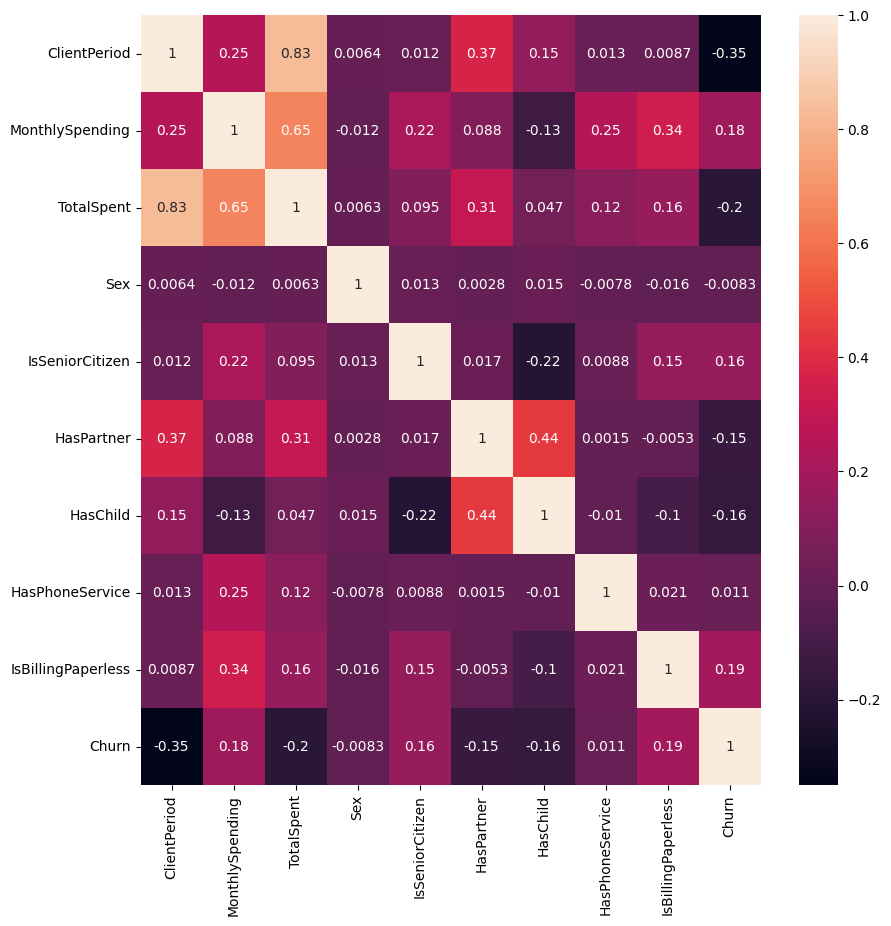

In [29]:
ax = sns.heatmap(train_preprocessed.corr(), annot=True, fmt='.2g')
ax.figure.set_figwidth(10)
ax.figure.set_figheight(10)

# Применение линейных моделей

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [48]:
cat_features = [
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'PaymentMethod'
]
num_features = num_cols

In [49]:
train_preprocessed

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,1,0,1,1,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,0,Mailed check,0
1,72,25.85,1872.20,1,0,1,0,1,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,0,Credit card (automatic),0
2,1,75.90,75.90,1,0,0,0,1,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,1,Electronic check,1
3,32,79.30,2570.00,0,1,1,0,1,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,0,Mailed check,0
4,60,115.25,6758.45,0,0,1,1,1,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,0,Credit card (automatic),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,3,30.40,82.15,1,0,0,0,0,No phone service,DSL,No,No,No,Yes,No,No,Month-to-month,0,Electronic check,0
5278,50,44.45,2188.45,1,0,1,0,0,No phone service,DSL,Yes,No,No,Yes,Yes,No,One year,1,Bank transfer (automatic),0
5279,1,55.05,55.05,1,0,0,0,1,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,0,Mailed check,0
5280,29,76.00,2215.25,0,0,0,0,1,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Credit card (automatic),0


In [81]:
pipe = Pipeline([
    ('transformer', ColumnTransformer([
                                ('categorical', OneHotEncoder(), cat_features),
                                ('numerical', StandardScaler(), num_features)
                    ], remainder='passthrough')
    ),
    ('classifier', LogisticRegression()),
])

In [82]:
pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  ['HasMultiplePhoneNumbers',
                                                   'HasInternetService',
                                                   'HasOnlineSecurityService',
                                                   'HasOnlineBackup',
                                                   'HasDeviceProtection',
                                                   'HasTechSupportAccess',
                                                   'HasOnlineTV',
                                                   'HasMovieSubscription',
                                                   'HasContractPhone',
                                                   'PaymentMethod']),
                                                 ('numerical', StandardScaler(),
                                                  ['ClientPeriod',
                                                   'MonthlySpending',
                                                   'TotalSpent'])])),
                ('classifier', LogisticRegression())])

In [83]:
param_grid = {
    "classifier__C": [100, 10, 1, 0.1, 0.01, 0.001],
}

In [84]:
gs = GridSearchCV(pipe, param_grid=param_grid, scoring="roc_auc", n_jobs=-1, cv=5, verbose=10)

In [85]:
gs.fit(train_preprocessed.drop('Churn', axis=1), train_preprocessed.Churn)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['HasMultiplePhoneNumbers',
                                                                          'HasInternetService',
                                                                          'HasOnlineSecurityService',
                                                                          'HasOnlineBackup',
                                                                          'HasDeviceProtection',
                                                                          'HasTechSupportAccess',
                                                                          'HasOnlineTV',
                                                                          'HasMovieSubscription',
                                                                          'HasContractPhone',
                                                                          'PaymentMethod']),
                                                                        ('numerical',
                                                                         StandardScaler(),
                                                                         ['ClientPeriod',
                                                                          'MonthlySpending',
                                                                          'TotalSpent'])])),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'classifier__C': [100, 10, 1, 0.1, 0.01, 0.001]},
             scoring='roc_auc', verbose=10)

In [86]:
gs.best_score_

0.8451102185255334

In [88]:
gs.best_params_

{'classifier__C': 100}

In [97]:
submission = pd.read_csv('./submission.csv')

submission['Churn'] = gs.best_estimator_.predict_proba(test_preprocessed)[:, 1]
submission.to_csv('./linear_with_gscv.csv', index=False)

In [96]:
submission # -> 0.84583 на паблике

,Id,Churn
0,0,0.037069
1,1,0.735883
2,2,0.682716
3,3,0.005594
4,4,0.001189
...,...,...
1756,1756,0.097058
1757,1757,0.025190
1758,1758,0.749493
1759,1759,0.644257
